In [26]:
import numpy as np
import csv
import time
import math

np.random.seed(1234)
def randomize(): np.random.seed(time.time())
    
def loss_min_max(loss):
    if math.isnan(loss):
        loss = 1e+5
    else:
        loss = min(float(loss), 1e+5)
        loss = max(float(loss), 1e-10)
    return loss

def acc_min_max(acc):
    if math.isnan(acc):
        acc = 0
    else:
        acc = max(float(acc), 1e-10)
        acc = min(float(acc), 100)
    return acc
    

def mutliprocess_exec(epoch_count=10, mb_size=10, report=1):
    return_dict = model_evaluate_multiprocess(epoch_count, report)
    loss, acc = kfold_model_evaluate_result(return_dict)
    print('K-Fold result')
    print('loss : {} , accuracy : {}'.format(loss, acc))
    return loss

def load_abalone_dataset():
    with open('../../data/chap01/abalone.csv') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader, None)
        rows = []
        for row in csvreader:
            rows.append(row)
            
    global data, input_cnt, output_cnt
    input_cnt, output_cnt = 10, 1
    data = np.zeros([len(rows), input_cnt+output_cnt])

    for n, row in enumerate(rows):
        if row[0] == 'I': data[n, 0] = 1
        if row[0] == 'M': data[n, 1] = 1
        if row[0] == 'F': data[n, 2] = 1
        data[n, 3:] = row[1:]
        
class mp_model():    
    def __init__(self, RND_MEAN = 0, RND_STD = 0.003, LEARNING_RATE = 0.001, input_cnt = 10, output_cnt=1):
        self.input_cnt, self.output_cnt = input_cnt, output_cnt
        self.RND_MEAN = RND_MEAN
        self.RND_STD = RND_STD
        self.LEARNING_RATE = LEARNING_RATE
        
        self.data = []
        
        self.weight = np.random.normal(self.RND_MEAN, self.RND_STD,[self.input_cnt, self.output_cnt])
        self.bias = np.zeros([self.output_cnt])
    
    def run_train(self, x, y):
        output, aux_nn = self.forward_neuralnet(x)
        loss, aux_pp = self.forward_postproc(output, y)
        loss = loss_min_max(loss)
        accuracy = self.eval_accuracy(output, y)
        accuracy = acc_min_max(accuracy)

        G_loss = 1.0
        G_output = self.backprop_postproc(G_loss, aux_pp)
        self.backprop_neuralnet(G_output, aux_nn)

        return loss, accuracy

    def run_test(self, x, y):
        output, _ = self.forward_neuralnet(x)
        accuracy = self.eval_accuracy(output, y)
        accuracy = acc_min_max(accuracy)
        return accuracy

    def run_test_acc_loss(self, x,y):
        output, _ = self.forward_neuralnet(x)
        loss, aux_pp = self.forward_postproc(output, y)
        loss = loss_min_max(loss)
        accuracy = self.eval_accuracy(output, y)
        accuracy = acc_min_max(accuracy)
        return accuracy, loss
    
    def forward_neuralnet(self, x):
        #global weight, bias
        output = np.matmul(x, self.weight) + self.bias
        return output, x

    def backprop_neuralnet(self, G_output, x):
        #global weight, bias
        g_output_w = x.transpose()

        G_w = np.matmul(g_output_w, G_output)
        G_b = np.sum(G_output, axis=0)

        self.weight -= self.LEARNING_RATE * G_w
        self.bias -= self.LEARNING_RATE * G_b
    
    def forward_postproc(self, output, y):
        diff = output - y
        square = np.square(diff)
        loss = np.mean(square)
        loss = loss_min_max(loss)
        return loss, diff

    def backprop_postproc(self, G_loss, diff):
        shape = diff.shape

        g_loss_square = np.ones(shape) / np.prod(shape)
        g_square_diff = 2 * diff
        g_diff_output = 1

        G_square = g_loss_square * G_loss
        G_diff = g_square_diff * G_square
        G_output = g_diff_output * G_diff

        return G_output
    
    def eval_accuracy(self, output, y):
        mdiff = np.mean(np.abs((output - y)/y))
        return 1 - mdiff
    
    def backprop_postproc_oneline(self, G_loss, diff):  # backprop_postproc() 대신 사용 가능
        return 2 * diff / np.prod(diff.shape)
    
    def run_train(self,x, y):
        output, aux_nn = self.forward_neuralnet(x)
        loss, aux_pp = self.forward_postproc(output, y)
        loss = loss_min_max(loss)
        accuracy = self.eval_accuracy(output, y)
        accuracy = acc_min_max(accuracy)

        G_loss = 1.0
        G_output = self.backprop_postproc(G_loss, aux_pp)
        self.backprop_neuralnet(G_output, aux_nn)

        return loss, accuracy

    def run_test(self,x, y):
        output, _ = self.forward_neuralnet(x)
        accuracy = self.eval_accuracy(output, y)
        accuracy = acc_min_max(accuracy)
        return accuracy

    def run_test_acc_loss(self,x,y):
        output, _ = self.forward_neuralnet(x)
        loss, aux_pp = self.forward_postproc(output, y)
        loss = loss_min_max(loss)
        accuracy = self.eval_accuracy(output, y)
        accuracy = acc_min_max(accuracy)
        return accuracy, loss

    
    
class mp_training():
    def __init__(self, RND_MEAN = 0, RND_STD = 0.003, LEARNING_RATE = 0.01, input_cnt = 10, output_cnt=1):
        self.input_cnt, self.output_cnt = input_cnt, output_cnt
        self.RND_MEAN = RND_MEAN
        self.RND_STD = RND_STD
        self.LEARNING_RATE = LEARNING_RATE
        
        self.data = []
        
    
    def load_abalone_dataset(self,):
        with open('../../data/chap01/abalone.csv') as csvfile:
            csvreader = csv.reader(csvfile)
            next(csvreader, None)
            rows = []
            for row in csvreader:
                rows.append(row)

        #input_cnt, output_cnt = 10, 1
        self.data = np.zeros([len(rows), self.input_cnt+self.output_cnt])

        for n, row in enumerate(rows):
            if row[0] == 'I': self.data[n, 0] = 1
            if row[0] == 'M': self.data[n, 1] = 1
            if row[0] == 'F': self.data[n, 2] = 1
            self.data[n, 3:] = row[1:]
            
            
    def kfold_data(self,):
        import sklearn
        from sklearn.model_selection import KFold
        data = self.data
        kf = KFold(n_splits=10, shuffle=True)
        kf.get_n_splits(data)
        kfold_data = {}
        for index, (train_index, test_index) in enumerate(kf.split(data)):
            train_data = data[train_index]
            test_data = data[test_index]
            kfold_data[index] = {'train' : train_data, 'test' : test_data}
        return kfold_data

    def kfold_return_train(self,n_fold, kfold_data):
        output_cnt = self.output_cnt
        if n_fold not in range(10):
            print('{} is not in range(10)'.format(n_fold))
            raise NameError('Change n_fold')
        train_data = kfold_data[n_fold]['train']
        #test_data = kfold_data[n_fold]['test']
        train_data_input = train_data[:, :-output_cnt]
        train_data_output = train_data[:, -output_cnt:]
        return [train_data_input, train_data_output]

    def kfold_return_test(self,n_fold, kfold_data):
        #global output_cnt
        output_cnt = self.output_cnt
        if n_fold not in range(10):
            print('{} is not in range(10)'.format(n_fold))
            raise NameError('Change n_fold')
        #train_data = kfold_data[n_fold]['train']
        test_data = kfold_data[n_fold]['test']
        test_data_input = test_data[:, :-output_cnt]
        test_data_output = test_data[:, -output_cnt:]
        return [test_data_input, test_data_output]
    

    def model_train_multiprocess(self,epoch_count, mb_size, report):
        from multiprocessing import Process, Manager
        _kfold_data = self.kfold_data()
        case_zip = []
        for index in range(10):
            train_data = self.kfold_return_train(n_fold=index, kfold_data=_kfold_data)
            test_data = self.kfold_return_test(n_fold=index, kfold_data=_kfold_data)
            case_zip.append((train_data, test_data))

        manager = Manager()
        return_dict = manager.dict()

        procs = []
        for index, (train_data, test_data) in enumerate(case_zip):
            proc = Process(target=self.train_test_multiprocess,
                           args=(train_data,test_data, epoch_count, mb_size, report,
                               index, return_dict),
                           name='{}-fold'.format(index)
                          )
            procs.append(proc)
            proc.start()

        for proc in procs:
            proc.join()

        return return_dict


    def kfold_model_evaluate_result(self,return_dict):
        losses = []
        accuracy = []
        for index in range(10):
            loss = return_dict[index][1]
            acc = return_dict[index][0]
            losses.append(loss)
            accuracy.append(acc)

        mean_loss = np.array(losses).mean()
        mean_acc = np.array(accuracy).mean()

        return mean_loss, mean_acc


    def train_test_multiprocess(self,train_data, test_data, epoch_count, mb_size, report,
                                proc_num=None,return_dict = None):
        
        model = mp_model(RND_MEAN = self.RND_MEAN,
                         RND_STD = self.RND_STD,
                         LEARNING_RATE =self.LEARNING_RATE,
                         input_cnt = self.input_cnt,
                         output_cnt=self.output_cnt)

        test_x, test_y = test_data[0], test_data[1]
        train_x, train_y = train_data[0], train_data[1]
        
        batch_num = len(train_x) // mb_size + 1

        for epoch in range(epoch_count):
            losses, accs = [], []

            for n in range(batch_num):
                n_batch = mb_size
                _train_x = train_x[n*n_batch:(n+1)*n_batch]
                _train_y = train_y[n*n_batch:(n+1)*n_batch]
                loss, acc = model.run_train(_train_x, _train_y)
                losses.append(loss)
                accs.append(acc)

            if report > 0 and (epoch+1) % report == 0:
                acc, loss_ = model.run_test_acc_loss(test_x, test_y)
                #print('Epoch {}: loss={:5.3f}, accuracy={:5.3f}/{:5.3f}'. \
                #      format(epoch+1, np.mean(losses), np.mean(accs), acc))

        final_acc, final_loss = model.run_test_acc_loss(test_x, test_y)
        
        final_acc = acc_min_max(final_acc)
        final_loss = loss_min_max(final_loss)
        
        #print('{} process'.format(proc_num))
        #print('\nFinal Test: final accuracy = {:5.3f}'.format(final_acc))

        results = [final_acc, final_loss]
        if proc_num is not None and return_dict is not None:
            return_dict[proc_num] = results

        return final_loss

    def mutliprocess_exec(self,epoch_count=100, mb_size=100, report=1):
        self.load_abalone_dataset()
        return_dict = self.model_train_multiprocess(epoch_count, mb_size,report)
        loss, acc = self.kfold_model_evaluate_result(return_dict)
        #print('K-Fold result')
        print('loss : {} , accuracy : {}'.format(loss, acc))
        return loss




In [27]:
mp = mp_training(RND_MEAN = 0, RND_STD = 0.003, LEARNING_RATE = 0.01, input_cnt = 10, output_cnt=1)

In [28]:
result = mp.mutliprocess_exec(epoch_count=20, mb_size=100)

loss : 6.849370281789142 , accuracy : 0.818411547459122


In [29]:
result

6.849370281789142

In [30]:
min([0.0001,0.00002])

2e-05

In [31]:
import numpy as np
import skopt
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from skopt.utils import use_named_args

hp_dict = {
    'RND_MEAN' : 0,
    'RND_STD' : 0.003,
    'LEARNING_RATE' : 0.01
    }

default_HP = list(hp_dict.values())

def model_tunning(hp_list):
    HP_list2dict = {
    'RND_MEAN' : int(hp_list[0]),
    'RND_STD' : float(hp_list[1]),
    'LEARNING_RATE' : float(hp_list[2])
    }
    print("======================start trainning=======================")
    print(HP_list2dict.items())
    print('\n')
    
    mp = mp_training(RND_MEAN = hp_list[0], RND_STD = hp_list[1], LEARNING_RATE = hp_list[2],
                     input_cnt = 10, output_cnt=1)
    
    loss = mp.mutliprocess_exec(epoch_count=20, mb_size=64)
    print('\n')
    print("======================end trainning=======================")
    return loss

dim_RND_MEAN_nodes = Integer(low=-100, high=100, name='RND_MEAN')
dim_RND_STD_nodes = Real(low=1e-8, high=1.0, prior='log-uniform', name='RND_STD')
dim_learning_rate_nodes = Real(low=1e-6, high=1.0, prior='log-uniform',name='LEARNING_RATE')

dimension_HP = [
                dim_RND_MEAN_nodes  ,
                dim_RND_STD_nodes  ,
                dim_learning_rate_nodes
                ]



n_cell = 200
n_random_starts = 50

gp_fitting = gp_minimize(func=model_tunning,
                        dimensions=dimension_HP,
                        n_calls=n_cell,
                        n_random_starts=n_random_starts,
                        acq_func='EI',
                        x0=default_HP
                        )

======================start trainning=======================
dict_items([('RND_MEAN', 0), ('RND_STD', 0.003), ('LEARNING_RATE', 0.01)])


loss : 6.724868941158927 , accuracy : 0.821005618161115


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', 28), ('RND_STD', 0.0015365638407710313), ('LEARNING_RATE', 3.1341142121632572e-06)])


loss : 9260.539964418847 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -68), ('RND_STD', 1.1664976792793522e-06), ('LEARNING_RATE', 2.960464241761588e-06)])


loss : 71536.38804038521 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -75), ('RND_STD', 0.00014321964116988236), ('LEARNING_RATE', 0.00010073861801226746)])


loss : 23130.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/loca

loss : 100000.0 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -21), ('RND_STD', 1.7166648627877116e-08), ('LEARNING_RATE', 0.09559773781824585)])


loss : 6.76742521895653 , accuracy : 0.8300090182901096


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', 26), ('RND_STD', 1.2550174652803462e-05), ('LEARNING_RATE', 2.564410004790965e-05)])


loss : 5806.916741204242 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', 76), ('RND_STD', 1.7271519534153333e-08), ('LEARNING_RATE', 3.5207812168191396e-06)])


loss : 76805.13331221328 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=====================

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = 

loss : 100000.0 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -67), ('RND_STD', 0.30436443334967633), ('LEARNING_RATE', 0.0013265935391926097)])


loss : 90.47250787229606 , accuracy : 0.09706653526341119


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -4), ('RND_STD', 0.037022003773899095), ('LEARNING_RATE', 5.650341508203085e-05)])


loss : 310.12759899475293 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -16), ('RND_STD', 0.014697780975882455), ('LEARNING_RATE', 0.000749575603020056)])


loss : 11.864760713906701 , accuracy : 0.7092072024423464


======================end trainning=======================
======================start trainning==========

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/loca

loss : 100000.0 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -22), ('RND_STD', 3.134638757723874e-08), ('LEARNING_RATE', 6.696892849047399e-05)])


loss : 3660.7258610059534 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -37), ('RND_STD', 0.03436662244176081), ('LEARNING_RATE', 0.00011268851097183885)])


loss : 5123.461599448882 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -48), ('RND_STD', 4.552132959285487e-08), ('LEARNING_RATE', 2.246752126119364e-05)])


loss : 28230.764558910112 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_ite

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/loca

loss : 100000.0 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -20), ('RND_STD', 6.300219375607704e-07), ('LEARNING_RATE', 0.007510122301343477)])


loss : 8.615538155521298 , accuracy : 0.7635688909142186


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -47), ('RND_STD', 0.018536556257334597), ('LEARNING_RATE', 0.0008263956978615829)])


loss : 58.51185154974932 , accuracy : 0.2796920282085046


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -24), ('RND_STD', 0.006864569390027977), ('LEARNING_RATE', 2.681675146701415e-06)])


loss : 10194.260636676667 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=========

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/loca

loss : 100000.0 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -11), ('RND_STD', 4.475884404521478e-06), ('LEARNING_RATE', 6.517465416131486e-05)])


loss : 1149.6397274760723 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -5), ('RND_STD', 6.548588574888314e-08), ('LEARNING_RATE', 1.6113246189162145e-05)])


loss : 699.9754414456509 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', 77), ('RND_STD', 4.509608144500013e-08), ('LEARNING_RATE', 0.0008374467285351896)])


loss : 179.758402668644 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/loca

loss : 100000.0 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', 21), ('RND_STD', 5.085120496509394e-06), ('LEARNING_RATE', 0.000228274992284214)])


loss : 258.9824733511923 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', 59), ('RND_STD', 0.0014887511837155063), ('LEARNING_RATE', 0.0006098669688120491)])


loss : 138.38765873490803 , accuracy : 0.0020761521351259455


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', 36), ('RND_STD', 0.0813591769133345), ('LEARNING_RATE', 6.426985651044811e-05)])


loss : 7032.203001323598 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/loca

loss : 100000.0 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -89), ('RND_STD', 0.0006430109504096179), ('LEARNING_RATE', 0.0004041978663462232)])


loss : 782.8714839014085 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -39), ('RND_STD', 1.2972728271497385e-08), ('LEARNING_RATE', 0.005119624555262056)])


loss : 15.309642910427817 , accuracy : 0.6505551205775099


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', 20), ('RND_STD', 0.000592463239237805), ('LEARNING_RATE', 2.0313037747269337e-05)])


loss : 3455.683307975368 , accuracy : 1e-10


======================end trainning=======================
======================start trainning====================

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/loca

loss : 100000.0 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', 20), ('RND_STD', 0.40232900946272543), ('LEARNING_RATE', 0.2889990041398254)])


loss : 7.882561794485997 , accuracy : 0.8382887338360536


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -79), ('RND_STD', 0.0050662307677483), ('LEARNING_RATE', 1.7749054209077096e-05)])


loss : 78256.0851155312 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -58), ('RND_STD', 0.0007636634127279728), ('LEARNING_RATE', 0.028875577165081795)])


loss : 13.868629666657503 , accuracy : 0.6968829093362986


======================end trainning=======================
======================start trainning================

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/loca

loss : 100000.0 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', 19), ('RND_STD', 0.16235243255048015), ('LEARNING_RATE', 0.000909991462117957)])


loss : 19.92639826121116 , accuracy : 0.6279441988960519


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', 74), ('RND_STD', 1.5953569095872885e-06), ('LEARNING_RATE', 0.0020563287325936334)])


loss : 92.98948446464024 , accuracy : 0.12726604643318656


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -21), ('RND_STD', 0.0016470883783991535), ('LEARNING_RATE', 0.0005839767120793557)])


loss : 19.82782619015436 , accuracy : 0.6289596749607357


======================end trainning=======================
======================start trainn

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/loca

loss : 100000.0 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', 14), ('RND_STD', 3.890216133606847e-07), ('LEARNING_RATE', 0.6238265648933445)])




/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/loca

loss : 100000.0 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', 1), ('RND_STD', 1.5850783598696233e-07), ('LEARNING_RATE', 0.026049464044341688)])


loss : 6.41801192040659 , accuracy : 0.8339179988139509


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', 88), ('RND_STD', 7.746930909315554e-05), ('LEARNING_RATE', 0.0013234662101396072)])


loss : 177.02375146883497 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', 63), ('RND_STD', 0.000798078045717364), ('LEARNING_RATE', 0.01748419576961384)])


loss : 13.500988027505306 , accuracy : 0.7152079416077628


======================end trainning=======================
======================start trainning=============

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/loca

loss : 100000.0 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -56), ('RND_STD', 2.558676108604809e-08), ('LEARNING_RATE', 8.517118478187125e-06)])


loss : 45718.7146365176 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', 74), ('RND_STD', 3.2816134332194726e-05), ('LEARNING_RATE', 0.995832694825518)])




/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/loca

loss : 100000.0 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', -70), ('RND_STD', 0.02910413432909512), ('LEARNING_RATE', 0.40600231705002704)])


loss : 100000.0 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', 57), ('RND_STD', 0.0001692325295876376), ('LEARNING_RATE', 0.014995912180364638)])


loss : 12.286043705638624 , accuracy : 0.7297832596080532


======================end trainning=======================
======================start trainning=======================
dict_items([('RND_MEAN', 46), ('RND_STD', 0.00023005883743582451), ('LEARNING_RATE', 1.1202755712152064e-05)])


loss : 24221.19397618388 , accuracy : 1e-10


======================end trainning=======================
======================start trainning=======================
dict_item

In [32]:
print(gp_fitting.x)
model_tunning(gp_fitting.x)

[-10, 6.360516116248919e-06, 0.1428318178794177]
======================start trainning=======================
dict_items([('RND_MEAN', -10), ('RND_STD', 6.360516116248919e-06), ('LEARNING_RATE', 0.1428318178794177)])


loss : 6.285381116147418 , accuracy : 0.8477099146877055


======================end trainning=======================


6.285381116147418

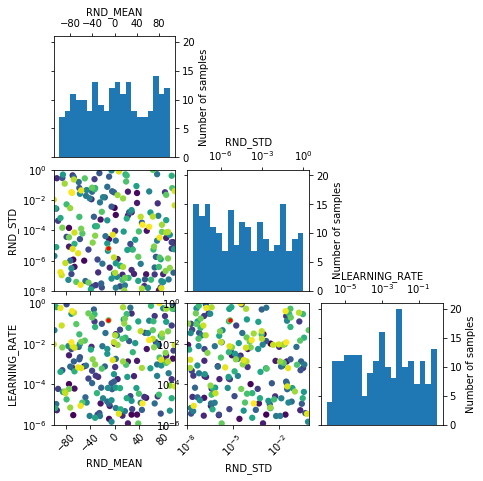

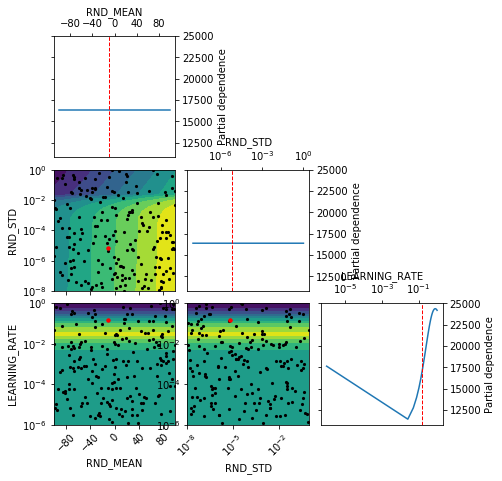

In [33]:
plot1 = plot_evaluations(gp_fitting)
plot2 = plot_objective(gp_fitting)

In [34]:
gp_fitting.specs

{'args': {'model_queue_size': None,
  'n_jobs': 1,
  'kappa': 1.96,
  'xi': 0.01,
  'n_restarts_optimizer': 5,
  'n_points': 10000,
  'callback': None,
  'verbose': False,
  'random_state': RandomState(MT19937) at 0x7FC25C06D780,
  'y0': None,
  'x0': [0, 0.003, 0.01],
  'acq_optimizer': 'auto',
  'acq_func': 'EI',
  'n_random_starts': 50,
  'n_calls': 200,
  'base_estimator': GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                           kernel=1**2 * Matern(length_scale=[1, 1, 1], nu=2.5),
                           n_restarts_optimizer=2, noise='gaussian',
                           normalize_y=True, optimizer='fmin_l_bfgs_b',
                           random_state=1229656529),
  'dimensions': Space([Integer(low=-100, high=100, prior='uniform', transform='normalize'),
         Real(low=1e-08, high=1.0, prior='log-uniform', transform='normalize'),
         Real(low=1e-06, high=1.0, prior='log-uniform', transform='normalize')]),
  'func': <function __main__.model